Imports

In [1]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson
import arviz as az

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input parameters for scraping

In [2]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [3]:
scrap_games(years)

Read data

In [3]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [4]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [6]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

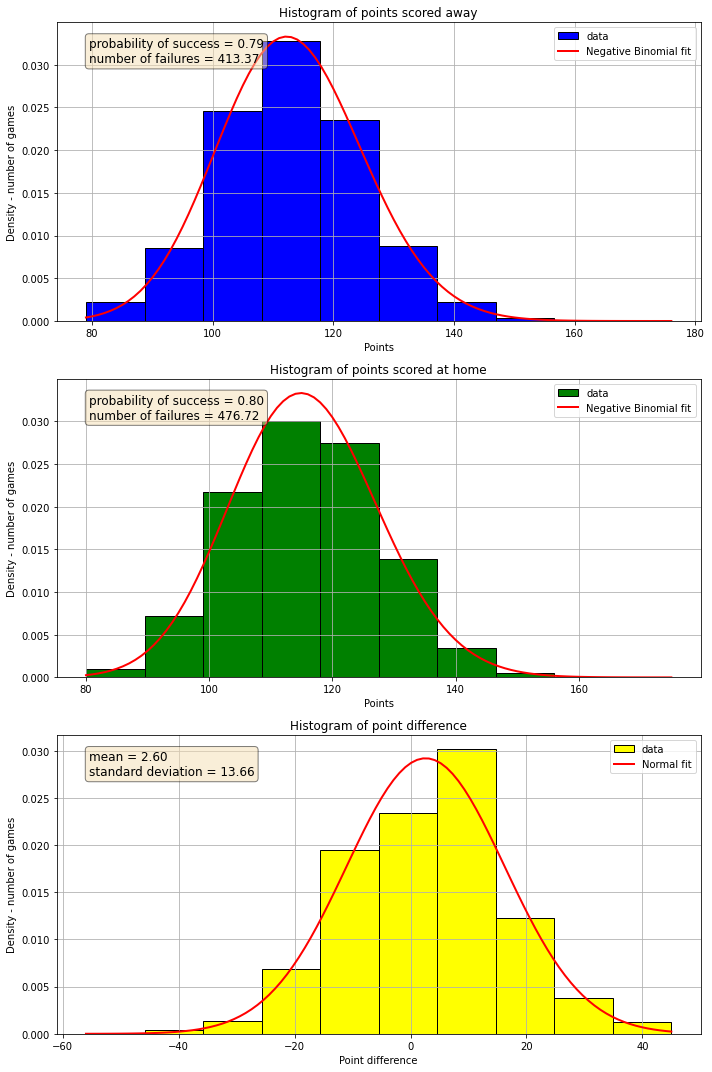

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [6]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

Model 2 - poisson

Predicting

In [9]:
with open('src/model/model_2.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}
parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}
transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k] = away_att_raw[k];
  }
  home_att[teams_number] = -s

In [29]:
model_2 = CmdStanModel(stan_file='src/model/model_2.stan')
samples = 1000
sim2=model_2.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=500,
                     chains=4,
                     fixed_param=False,
                     parallel_chains=4,
                     seed=122,
                     refresh=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_2.stan to exe file /app/src/model/model_2
INFO:cmdstanpy:compiled model executable: /app/src/model/model_2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██████▋   | 00:07 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██████████| 00:21 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████████| 00:23 Sampling completed                       
chain 2 |██████████| 00:23 Sampling completed                       
chain 3 |██████████| 00:23 Sampling completed                       
chain 4 |██████████| 00:23 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [30]:
mod_2 = sim2.draws_pd()
mod_2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_def[21],away_def[22],away_def[23],away_def[24],away_def[25],away_def[26],away_def[27],away_def[28],away_def[29],away_def[30]
0,1061260.0,0.933358,0.074175,6.0,63.0,0.0,-1061180.0,-0.002173,-0.008573,0.002321,...,-0.008310,-0.003986,-0.002873,-0.005760,0.022403,0.005192,-0.020371,0.055905,-0.031945,0.095405
1,1061260.0,0.905503,0.074175,6.0,63.0,0.0,-1061210.0,0.003731,0.017810,0.004290,...,0.007078,0.042840,0.006927,-0.000020,0.022284,0.019492,-0.025338,0.012216,-0.034519,0.088600
2,1061260.0,0.992866,0.074175,6.0,63.0,0.0,-1061190.0,-0.001044,-0.009223,0.014656,...,-0.000591,-0.001542,0.000416,0.007493,0.044714,0.013914,-0.034560,0.044790,-0.029689,0.116350
3,1061250.0,0.685546,0.074175,6.0,63.0,0.0,-1061180.0,0.004468,-0.003658,-0.003062,...,0.005248,0.018763,0.004558,-0.005776,0.006686,0.006271,-0.020145,0.022438,-0.050606,0.135272
4,1061250.0,0.943389,0.074175,6.0,63.0,0.0,-1061170.0,-0.002189,0.014065,0.011338,...,0.005822,0.021089,-0.002880,-0.000819,0.040949,0.024204,-0.026998,0.040681,-0.002103,0.110538


2023


/tmp/ipykernel_1082/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


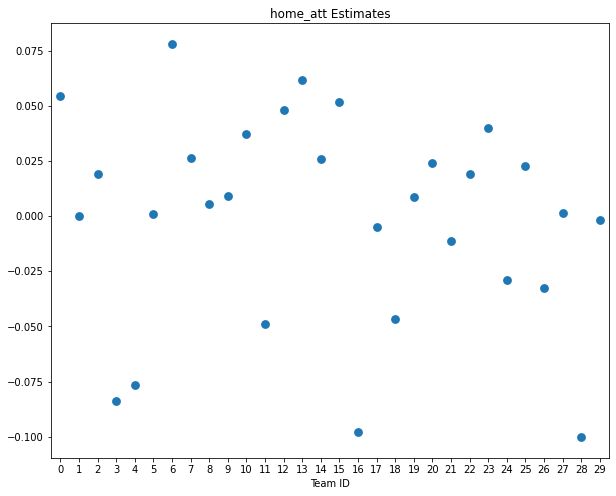

/tmp/ipykernel_1082/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


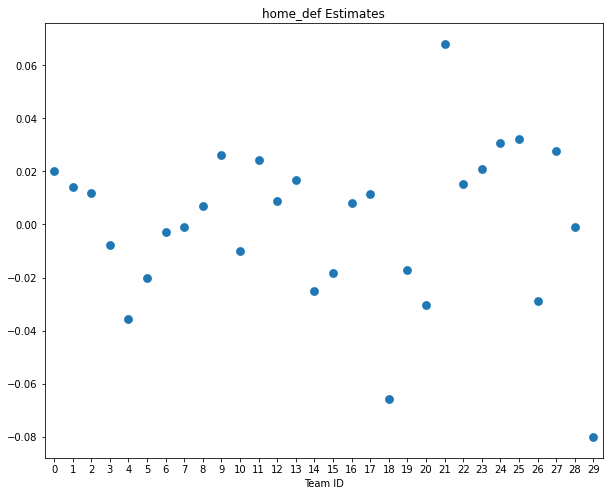

/tmp/ipykernel_1082/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


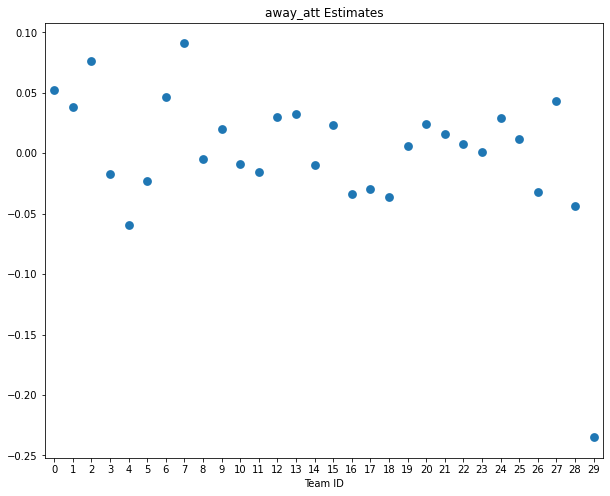

/tmp/ipykernel_1082/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


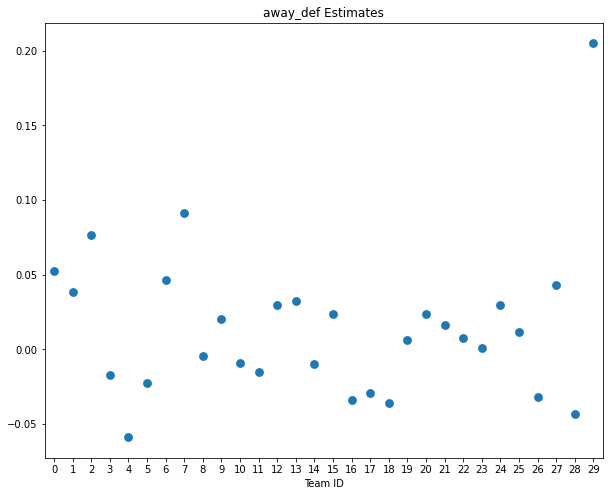

In [148]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
print(year)
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

In [31]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'off_set']
param_dict = {param: sim2.stan_variable(param) for param in parameters}

# Przykładowe dane do przewidywania (przykładowe ID drużyn)

season_games_pred1 = {2023: seasons_games[2023][200:220]}
pred_scores = []

# Przewidywanie wyników dla każdego meczu
for idx, row in season_games_pred1[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    home_score = row['home_team_score']
    away_score = row['away_team_score']
    
    # Pobieranie odpowiednich parametrów dla drużyn
    home_att = param_dict['home_att'][:, home_idx-1]
    home_def = param_dict['home_def'][:, away_idx-1]
    away_att = param_dict['away_att'][:, home_idx-1]
    away_def = param_dict['away_def'][:, away_idx-1]
    off_set = param_dict['off_set']
    
    # Tworzenie parametrów log_mu
    log_mu1 = home_att + away_def + off_set
    log_mu2 = home_def + away_att + off_set
    
    # Symulowanie z rozkładu Poissona dla uzyskania predyktywnej dystrybucji
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    print(y1[0:10], y2[0:10])
    # draw blocked
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
    # Obliczanie prawdopodobieństw wyników
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    pred_scores.append((np.mean(y1), np.mean(y2)))
    
    print(outcome_probabilities)

[ 72  95  78  74 114  88 103  97 105  91] [ 99 115  88 110  92  96 102  69  99 115]
   home_team_win_prob  away_team_win_prob
0               0.396               0.604
[100 100 100 107 104  85 100 109 105  95] [104  93  93 111 103  95  83 103  90  90]
   home_team_win_prob  away_team_win_prob
0               0.651               0.349
[ 90 124 109  88 113 113 112 110 111 100] [ 86 101 109 108  75 103 109  96 101 106]
   home_team_win_prob  away_team_win_prob
0               0.524               0.476
[ 81 103 102  97 102  89  93  83  87 106] [98 92 95 93 96 95 97 99 87 81]
   home_team_win_prob  away_team_win_prob
0               0.425               0.575
[106 117  94 115  98  95 111  92 111  98] [ 92 104  98  85  81 103 100 106 110  75]
   home_team_win_prob  away_team_win_prob
0               0.542               0.458
[ 99  94 109  88  96  84 110  95 105 103] [ 86  91  97  96 103  94  97  92  94 111]
   home_team_win_prob  away_team_win_prob
0               0.632               0.368
[ 

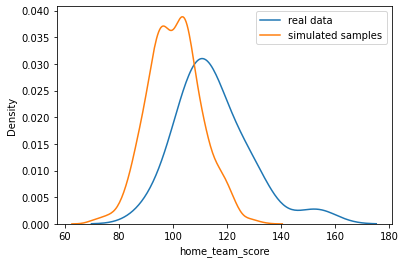

In [32]:
sns.kdeplot(data=season_games_pred1[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

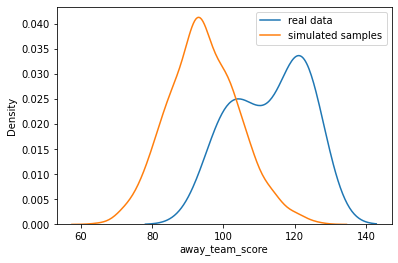

In [33]:
sns.kdeplot(data=season_games_pred1[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

## Model 3 - poisson

In [129]:
model_3 = CmdStanModel(stan_file='src/model/model_3.stan')
samples = 1000
sim3=model_3.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=500,
                     chains=4,
                     fixed_param=False,
                     parallel_chains=4,
                     seed=123,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▋   | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |██████████| 00:05 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
chain 4 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [130]:
mod_3 = sim3.draws_pd()
mod_3.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_att,mu_def,sigma_att,...,log_mu_away[1314],log_mu_away[1315],log_mu_away[1316],log_mu_away[1317],log_mu_away[1318],log_mu_away[1319],log_mu_away[1320],log_mu_away[1321],log_mu_away[1322],log_mu_away[1323]
0,1081490.0,0.927273,0.144674,4.0,15.0,0.0,-1081470.0,0.405520,0.305789,0.040716,...,4.62488,4.63309,4.62819,4.62488,4.65342,4.65342,4.64779,4.64779,4.65342,4.64779
1,1081490.0,0.866827,0.144674,3.0,15.0,0.0,-1081460.0,0.377357,0.299022,0.038382,...,4.65556,4.61498,4.63821,4.65556,4.63952,4.63952,4.63178,4.63178,4.63952,4.63178
2,1081500.0,0.990403,0.144674,4.0,15.0,0.0,-1081460.0,0.395683,0.293137,0.025450,...,4.63746,4.61665,4.63304,4.63746,4.65094,4.65094,4.66357,4.66357,4.65094,4.66357
3,1081510.0,0.910428,0.144674,3.0,7.0,0.0,-1081470.0,0.385827,0.298721,0.026466,...,4.64845,4.62296,4.63164,4.64845,4.66909,4.66909,4.65977,4.65977,4.66909,4.65977
4,1081500.0,0.533601,0.144674,3.0,7.0,0.0,-1081470.0,0.389470,0.297563,0.029138,...,4.64718,4.61960,4.62111,4.64718,4.63926,4.63926,4.62641,4.62641,4.63926,4.62641


In [131]:
season_games_pred2 = {2023: seasons_games[2023][200:220]}

# Number of samples for simulation
samples = 1000

# Extracting parameters from the Stan result
parameters = ['attack', 'defense', 'home_advantage']
param_dict = {param: sim3.stan_variable(param) for param in parameters}

# Predicting results for each game
for idx, row in season_games_pred2[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    
    # Retrieving appropriate parameters for the teams
    home_att = param_dict['attack'][:, home_idx-1]
    home_def = param_dict['defense'][:, home_idx-1]
    away_att = param_dict['attack'][:, away_idx-1]
    away_def = param_dict['defense'][:, away_idx-1]
    home_advantage = param_dict['home_advantage']
    
    # Creating log_mu parameters
    log_mu1 = home_advantage + home_att - away_def + np.log(100)
    log_mu2 = away_att - home_def + np.log(100)
    
    # Simulating from Poisson distribution to obtain predictive distribution
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    
    # Blocking draws
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    print(y1[0:10], y2[0:10])
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}\n")

[122 104 112 106 102 118 118 110 120  99] [ 95 113  99  91  96  94 104  94  92  94]
Game 201:
   home_team_win_prob  away_team_win_prob
0               0.858               0.142
Home Team Points Distribution: 112.508 ± 10.708498307419205
Away Team Points Distribution: 97.686 ± 9.744403727268283

[124 104 102 108 106 108 106 109 106 115] [ 99 107 111  96 131 107  96  95 126 113]
Game 202:
   home_team_win_prob  away_team_win_prob
0               0.537               0.463
Home Team Points Distribution: 108.124 ± 10.425383638025028
Away Team Points Distribution: 107.252 ± 10.287978227037614

[122 129 115 129 134  91  94 112 112 125] [125 103 113 118 121 124 112 103 113 128]
Game 203:
   home_team_win_prob  away_team_win_prob
0               0.574               0.426
Home Team Points Distribution: 116.555 ± 10.710040849595298
Away Team Points Distribution: 113.522 ± 10.877477464927244

[122 110 101 111 105 117 117  94 108  98] [128 112 124 116 120 122 109 116 117 130]
Game 204:
   home_tea

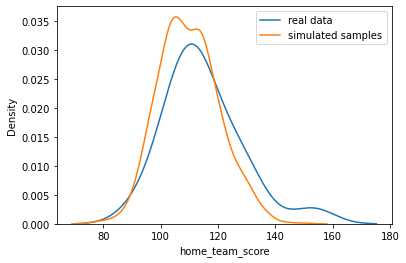

In [132]:
sns.kdeplot(data=season_games_pred2[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

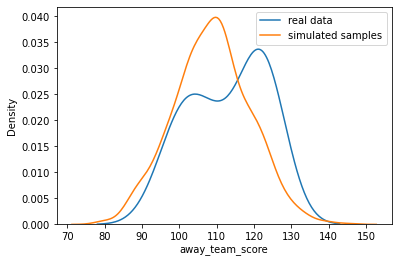

In [133]:
sns.kdeplot(data=season_games_pred1[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

## Model 4 - gamma

In [134]:
model_4 = CmdStanModel(stan_file='src/model/model_gamma.stan')
samples = 1000
sim4=model_4.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=500,
                     chains=4,
                     fixed_param=False,
                     parallel_chains=4,
                     seed=124,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████▋   | 00:06 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██████████| 00:37 Sampling completed                       
chain 2 |██████████| 00:37 Sampling completed                       
chain 3 |██████████| 00:37 Sampling completed                       
chain 4 |██████████| 00:37 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [135]:
mod_4 = sim4.draws_pd()
mod_4.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_att,mu_def,sigma_att,...,mu_away[1314],mu_away[1315],mu_away[1316],mu_away[1317],mu_away[1318],mu_away[1319],mu_away[1320],mu_away[1321],mu_away[1322],mu_away[1323]
0,-10130.2,0.958963,0.00647,3.0,7.0,0.0,10163.9,1.59003,1.50721,0.024222,...,105.983,103.091,102.146,105.983,104.369,104.369,102.987,102.987,104.369,102.987
1,-10131.6,0.853074,0.00647,4.0,15.0,0.0,10162.8,1.59789,1.49743,0.024448,...,102.167,102.350,101.780,102.167,105.446,105.446,105.471,105.471,105.446,105.471
2,-10141.5,0.836246,0.00647,4.0,15.0,0.0,10167.5,1.59290,1.50245,0.024386,...,103.035,103.345,100.040,103.035,106.130,106.130,102.137,102.137,106.130,102.137
3,-10131.4,0.901429,0.00647,4.0,15.0,0.0,10175.9,1.59206,1.50865,0.024743,...,104.280,101.283,101.202,104.280,103.514,103.514,103.577,103.577,103.514,103.577
4,-10140.9,0.791980,0.00647,4.0,15.0,0.0,10172.2,1.60100,1.51853,0.024733,...,102.052,104.844,101.600,102.052,104.758,104.758,103.107,103.107,104.758,103.107


In [136]:
season_games_pred3 = {2023: seasons_games[2023][200:220]}

# Number of samples for simulation
samples = 1000

# Extracting parameters from the Stan result
parameters = ['attack', 'defense', 'home_advantage']
param_dict = {param: sim4.stan_variable(param) for param in parameters}

# Predicting results for each game
for idx, row in season_games_pred3[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    
    # Retrieving appropriate parameters for the teams
    home_att = param_dict['attack'][:, home_idx-1]
    home_def = param_dict['defense'][:, home_idx-1]
    away_att = param_dict['attack'][:, away_idx-1]
    away_def = param_dict['defense'][:, away_idx-1]
    home_advantage = param_dict['home_advantage']
    
    # Creating log_mu parameters
    log_mu1 = home_advantage + home_att - away_def + np.log(100)
    log_mu2 = away_att - home_def + np.log(100)
    
    # Simulating from Poisson distribution to obtain predictive distribution
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    
    # Blocking draws
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    print(y1[0:10], y2[0:10])
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}\n")

[117 101 109 102  99 103  99 106 105 111] [111  89  94  90  75  86 103 102  81 105]
Game 201:
   home_team_win_prob  away_team_win_prob
0               0.842               0.158
Home Team Points Distribution: 112.748 ± 10.76078510146913
Away Team Points Distribution: 97.679 ± 9.764525538908687

[103 124  91 103 118  97 108 126 101 103] [ 98 102  96 106 110 107 120 103 100 114]
Game 202:
   home_team_win_prob  away_team_win_prob
0               0.542               0.458
Home Team Points Distribution: 108.23 ± 10.845233976268101
Away Team Points Distribution: 107.367 ± 10.192953987927151

[119 128 125 111  99 111  93  95 104 115] [130 125 106 103 126 109 115 133 111 112]
Game 203:
   home_team_win_prob  away_team_win_prob
0               0.613               0.387
Home Team Points Distribution: 117.162 ± 10.920062087735582
Away Team Points Distribution: 112.69 ± 10.68390846085832

[104 108 113 109 109 107 105  94 104 113] [134 111 121 120 124 111 121 111 116 117]
Game 204:
   home_team_wi

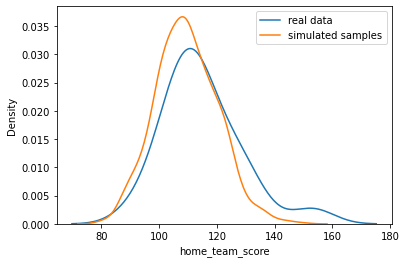

In [137]:
sns.kdeplot(data=season_games_pred3[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

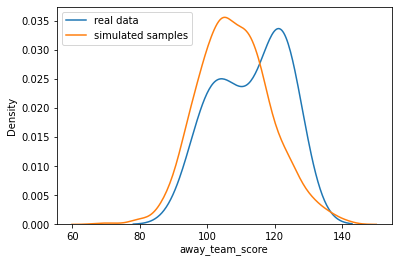

In [138]:
sns.kdeplot(data=season_games_pred3[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

Models comparison

In [ ]:
comp_dict = {'m3': sim3, 'm4': sim4}
comp = az.compare(comp_dict, ic='waic', scale='deviance')